# Przygotowanie

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Lecimy z koksem(czystym)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import os

In [0]:
# Dwie klasy lepsze od 1!
NUM_CLASSES = 2

# 3 kanały koloru
CHANNELS = 3

# Wielkość ResNetu
IMAGE_RESIZE = 224
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 10

STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

BATCH_SIZE_TRAINING = 10
BATCH_SIZE_VALIDATION = 10

BATCH_SIZE_TESTING = 1

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.applications.resnet import ResNet50, ResNet101, ResNet152

from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import optimizers

Using TensorFlow backend.


In [0]:
all_results = {}

# Data
image_size = IMAGE_RESIZE
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
path = '/content/drive/My Drive/Data'
slash = '/'
train_generator = data_generator.flow_from_directory(
        directory=path + slash + 'test' + slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')
validation_generator = data_generator.flow_from_directory(
        directory=path + slash + 'valid'+ slash,
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical')
  
# Callbacks
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = path + slash + 'saved_models' + slash + 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

test_generator = data_generator.flow_from_directory(
    directory = path + slash + 'show' + slash,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

TEST_DIR = path + slash + 'show' + slash

Found 12337 images belonging to 2 classes.
Found 9580 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [0]:
def do_the_job(resnet, name):

  print(f'{name}\n')


  # Model
  model = Sequential()
  model.add(resnet)
  model.add(Dense(512, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
  model.layers[0].trainable = False

  model.summary()

  # Optimizers
  model.compile(optimizer = 'adadelta', loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

  # Fit
  fit_history = model.fit_generator(
          train_generator,
          steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
          epochs = NUM_EPOCHS,
          validation_data=validation_generator,
          validation_steps=STEPS_PER_EPOCH_VALIDATION,
          callbacks=[cb_checkpointer, cb_early_stopper]
  )
  model.load_weights(path + slash + 'saved_models' + slash + 'best.hdf5')
  
  # Save
  model.save(path + slash + 'saved_models' + slash + name + '.h5')

  # Score
  scoreRes = model.evaluate_generator(
        generator=validation_generator
  )
  all_results[name] = scoreRes

  # Raport
  plt.figure(1, figsize = (15,8)) 
    
  plt.subplot(221)  
  plt.plot(fit_history.history['acc'])  
  plt.plot(fit_history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'valid']) 
      
  plt.subplot(222)  
  plt.plot(fit_history.history['loss'])  
  plt.plot(fit_history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'valid']) 

  plt.show()

  test_generator.reset()
  pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)
  predicted_class_indices = np.argmax(pred, axis = 1)

  print(f'class indices: {test_generator.class_indices}')

  f, ax = plt.subplots(5, 5, figsize = (15, 15))

  for i in range(0,25):
      imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
      imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
      
      predicted_class = str(predicted_class_indices[i])

      ax[i//5, i%5].imshow(imgRGB)
      ax[i//5, i%5].axis('off')
      ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))    

  plt.show()
  del model
  print(f'------------------')

VanilaResNet50_avg

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None

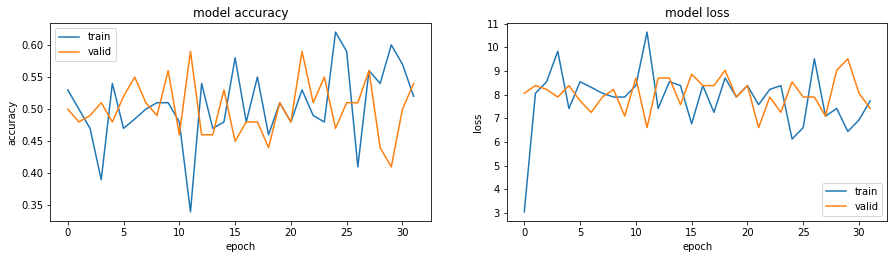

25/25 [==============================] - 9s 374ms/step
class indices: {'originals': 0, 'photoshops': 1}


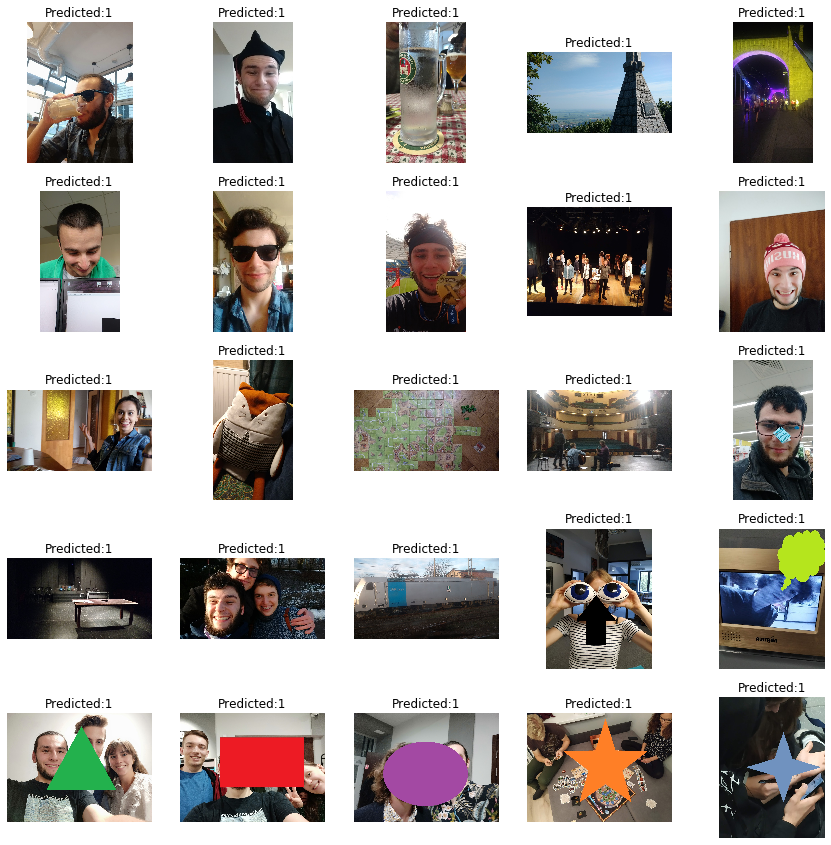

------------------


In [0]:
do_the_job(resnet=ResNet50(include_top = False, pooling = 'avg', weights = None), name='VanilaResNet50_avg')

VanilaResNet50_max

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_18 (Dense)             (None

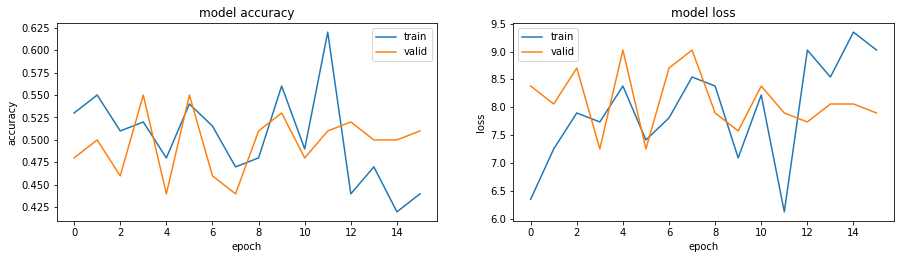

25/25 [==============================] - 9s 379ms/step
class indices: {'originals': 0, 'photoshops': 1}


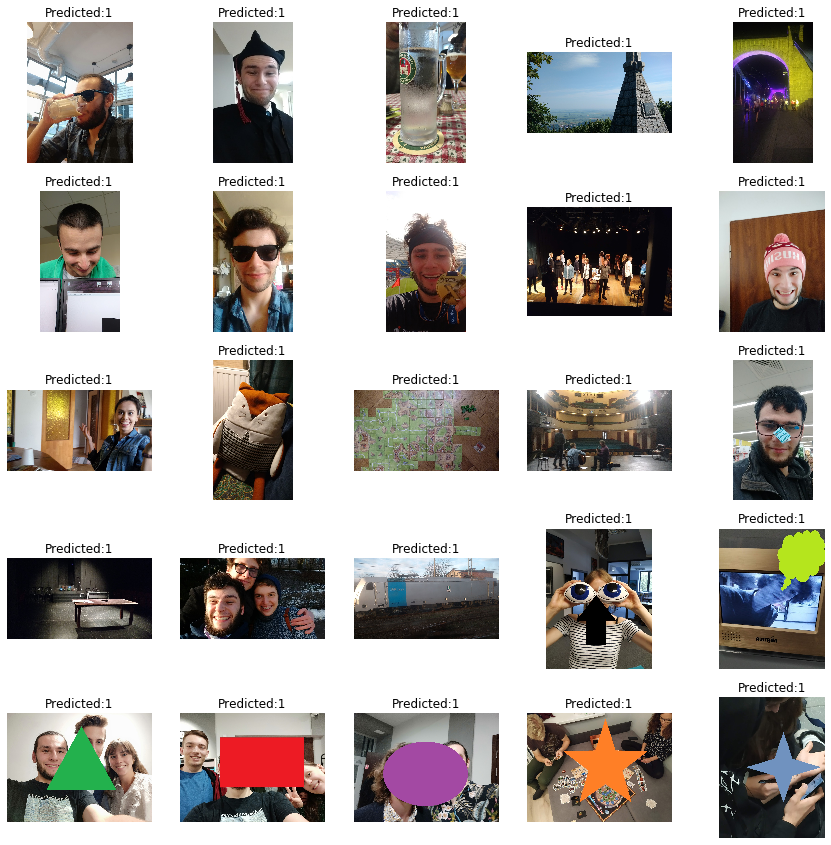

------------------


In [0]:
do_the_job(resnet=ResNet50(include_top = False, pooling = 'max', weights = None), name='VanilaResNet50_max')

VanilaResNet101_avg

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 2048)              42658176  
_________________________________________________________________
dense_19 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_24 (Dense)             (Non

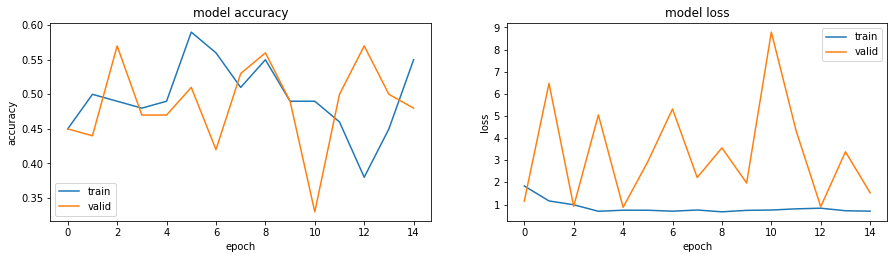

25/25 [==============================] - 16s 641ms/step
class indices: {'originals': 0, 'photoshops': 1}


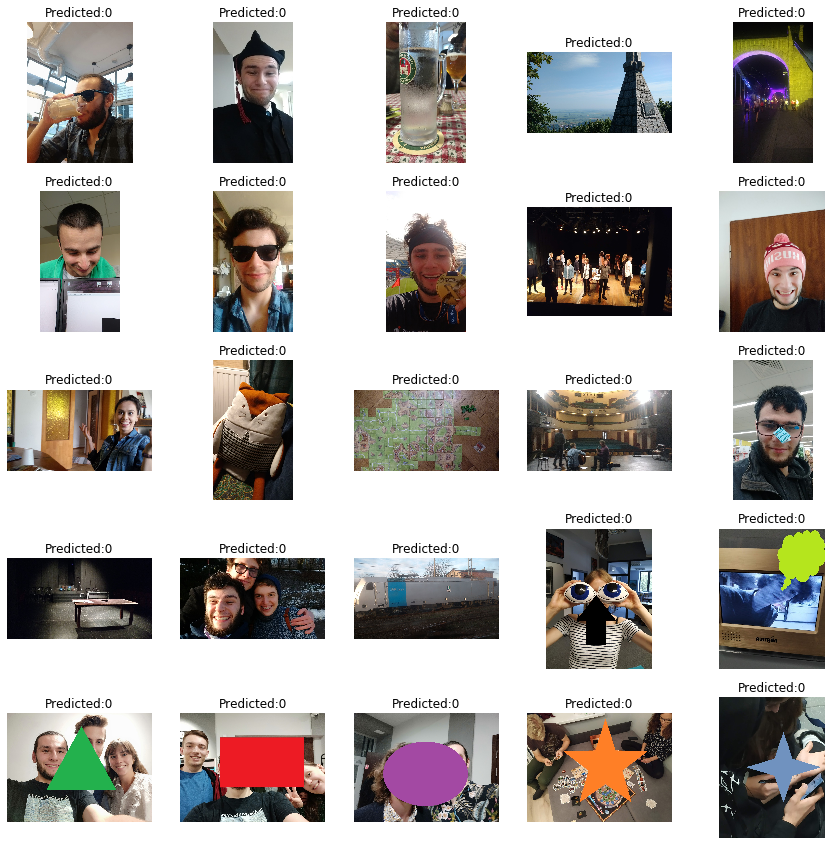

------------------


In [0]:
do_the_job(resnet=ResNet101(include_top = False, pooling = 'avg', weights = None), name='VanilaResNet101_avg')

VanilaResNet101_max

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 2048)              42658176  
_________________________________________________________________
dense_25 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_30 (Dense)             (Non

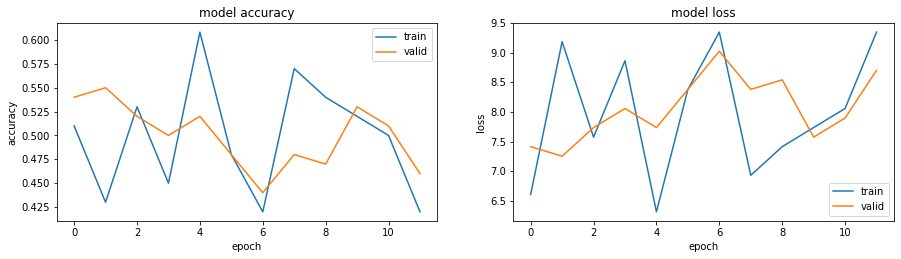

25/25 [==============================] - 17s 697ms/step
class indices: {'originals': 0, 'photoshops': 1}


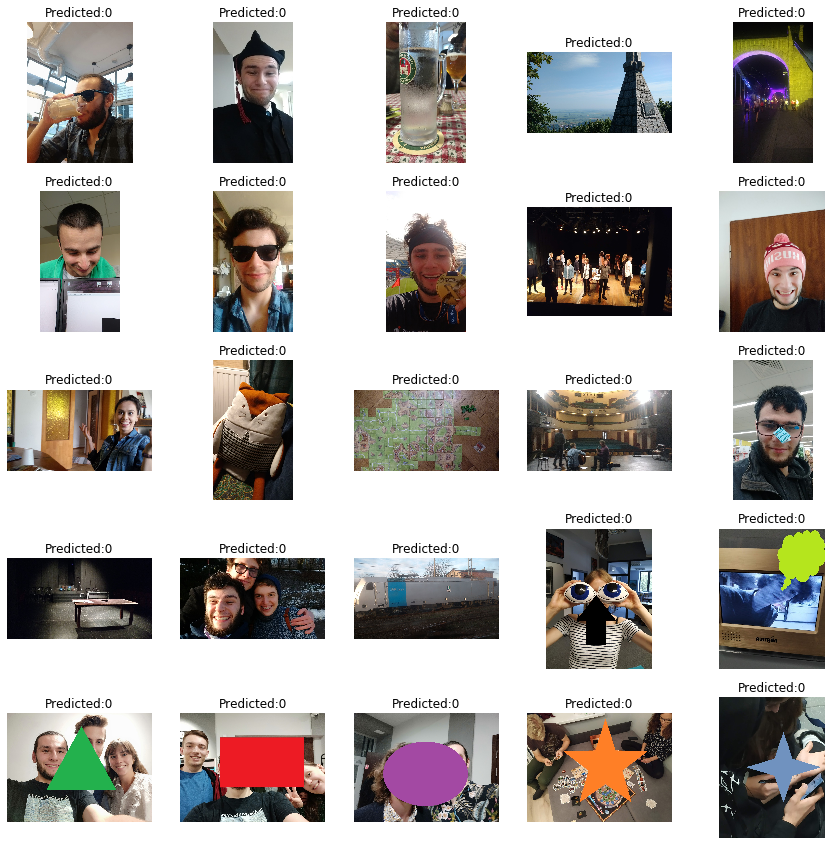

------------------


In [0]:
do_the_job(resnet=ResNet101(include_top = False, pooling = 'max', weights = None), name='VanilaResNet101_max')

VanilaResNet152_avg

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 2048)              58370944  
_________________________________________________________________
dense_31 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_32 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_33 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_36 (Dense)             (Non

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 109s 11s/step - loss: 0.6806 - acc: 0.5500 - val_loss: 7.5590 - val_acc: 0.5300
Epoch 14/100
10/10 [==============================] - 107s 11s/step - loss: 0.7040 - acc: 0.5000 - val_loss: 6.9072 - val_acc: 0.4700
Epoch 15/100
10/10 [==============================] - 107s 11s/step - loss: 0.7112 - acc: 0.4800 - val_loss: 0.9081 - val_acc: 0.4200
Epoch 16/100
10/10 [==============================] - 107s 11s/step - loss: 0.6978 - acc: 0.4900 - val_loss: 1.6124 - val_acc: 0.5800
Epoch 17/100
10/10 [==============================] - 107s 11s/step - loss: 0.6730 - acc: 0.5400 - val_loss: 6.5936 - val_acc: 0.5900
Epoch 18/100
10/10 [==============================] - 107s 11s/step - loss: 0.7067 - acc: 0.4300 - val_loss: 5.9192 - val_acc: 0.6100


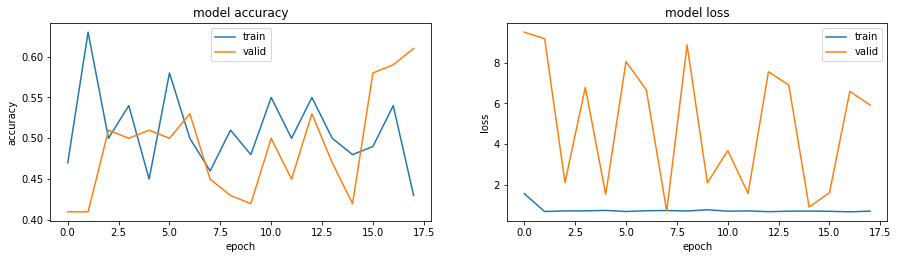

25/25 [==============================] - 25s 1s/step
class indices: {'originals': 0, 'photoshops': 1}


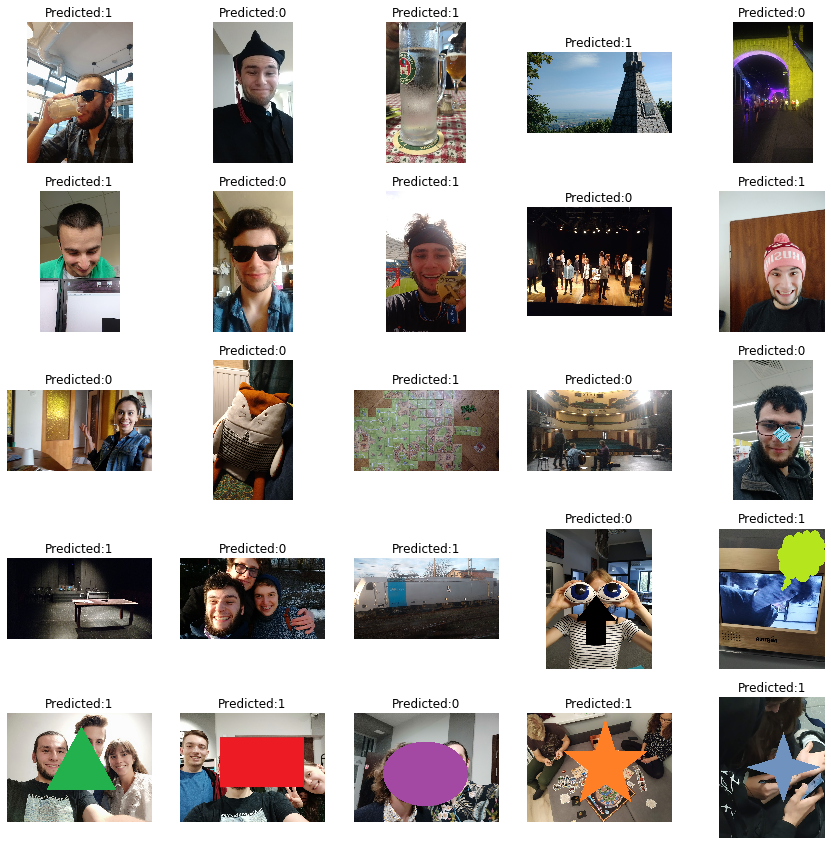

------------------


In [0]:
do_the_job(resnet=ResNet152(include_top = False, pooling = 'avg', weights = None), name='VanilaResNet152_avg')

VanilaResNet152_max

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 2048)              58370944  
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_39 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_40 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_41 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_42 (Dense)             (Non

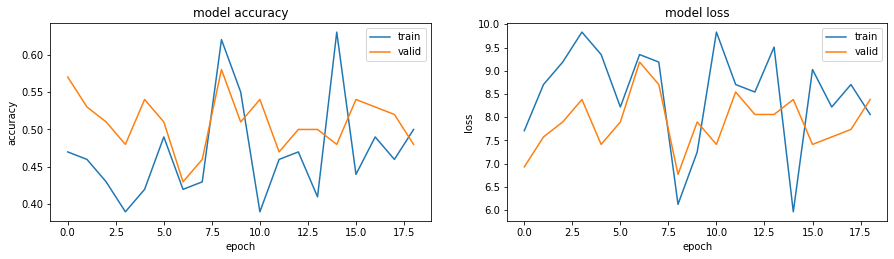

25/25 [==============================] - 27s 1s/step
class indices: {'originals': 0, 'photoshops': 1}


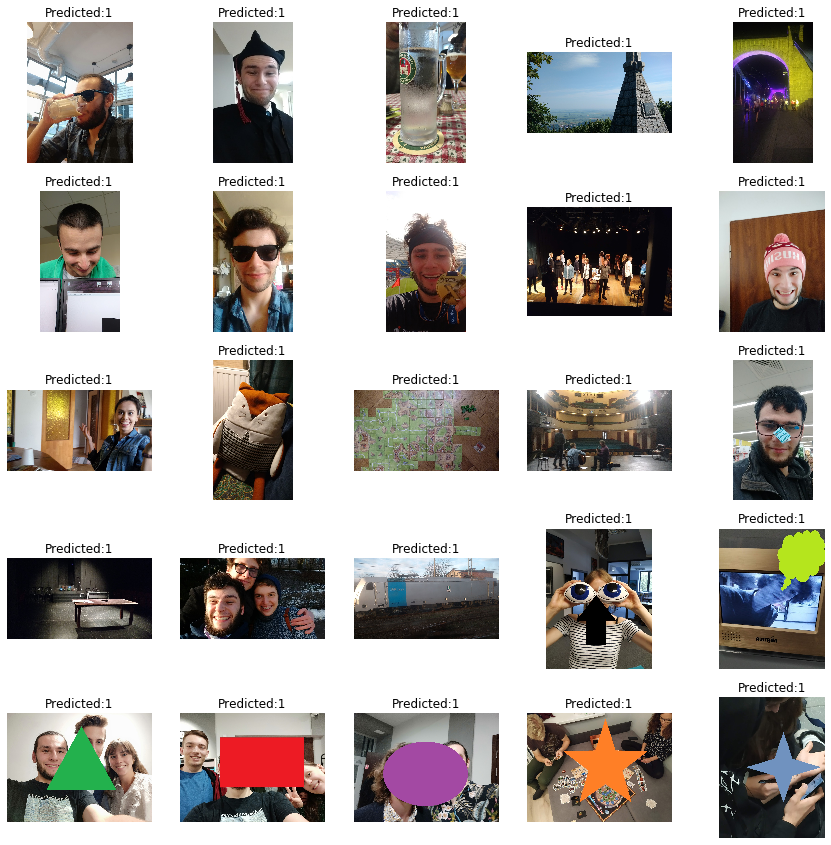

------------------


In [0]:
do_the_job(resnet=ResNet152(include_top = False, pooling = 'max', weights = None), name='VanilaResNet152_max')

In [0]:
all_results

{'VanilaResNet101_avg': [0.8407009588651717, 0.5000000071083828],
 'VanilaResNet101_max': [1.3552867115274974, 0.5000000067972937],
 'VanilaResNet152_avg': [0.696174303026936, 0.4849686909988056],
 'VanilaResNet152_max': [0.8308858323010124, 0.5002087749509697],
 'VanilaResNet50_avg': [8.05904774738005, 0.5000000065561998],
 'VanilaResNet50_max': [8.059047742029321, 0.5000000062762198]}